In [1]:
########################################
# importing packages
########################################
import numpy as np              
import pandas as pd             # data science essentials
import seaborn           as sns                      # enhanced data viz
import matplotlib.pyplot as plt # essential graphical output
import statsmodels.formula.api as smf # regression modeling
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.metrics import confusion_matrix         # confusion matrix
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression


# CART model packages
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend

# new packages
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

########################################
# loading data and setting display options
########################################
df = pd.read_excel('./GOT_character_predictions.xlsx')

# loading model performance
#missing this

# displaying the head of the dataset
df.head(n = 5)

,S.No,name,title,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
0,1,Viserys II Targaryen,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
1,2,Walder Frey,Lord of the Crossing,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
2,3,Addison Hill,Ser,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
3,4,Aemma Arryn,Queen,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,0,0,0,0,0,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
4,5,Sylva Santagar,Greenstone,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,0,0,0,1,0,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1


In [2]:
nans = df.isna().sum()

In [3]:
nans[nans > 0]

title            1008
culture          1269
dateOfBirth      1513
mother           1925
father           1920
heir             1923
house             427
spouse           1670
isAliveMother    1925
isAliveFather    1920
isAliveHeir      1923
isAliveSpouse    1670
age              1513
dtype: int64

In [4]:
# Number of Data points
len(df)

1946

In [5]:
# Mean age
print(df["age"].mean())

-1293.5635103926097


In [9]:
# Fill the nans
df["age"].fillna(df["age"].median(), inplace=True)
df["culture"].fillna("", inplace=True)

# Some nans values are nan because we dont know them so fill them with -1
df.fillna(value=-1, inplace=True)

In [12]:
# Drop columns 
drop = ["S.No", "name"]
df.drop(drop, inplace=True, axis=1)

# Save a copy of the dataset before one-hot encoding the features
# we will use this later
df2 = df.copy(deep=True)

In [15]:
########################################
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing x_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [16]:
df_corr = df.corr(method = 'pearson').round(2)

df_corr['isAlive'].sort_values(ascending = False)

isAlive                       1.00
book4_A_Feast_For_Crows       0.27
age                           0.05
book5_A_Dance_with_Dragons    0.03
book3_A_Storm_Of_Swords       0.01
isAliveSpouse                -0.03
isNoble                      -0.04
isMarried                    -0.05
dateOfBirth                  -0.06
book2_A_Clash_Of_Kings       -0.07
isAliveFather                -0.12
isAliveHeir                  -0.12
isAliveMother                -0.14
book1_A_Game_Of_Thrones      -0.15
popularity                   -0.18
numDeadRelations             -0.19
Name: isAlive, dtype: float64

In [17]:
df.loc[ : ,'isAlive'].value_counts(normalize = True).round(decimals = 2)

1    0.75
0    0.25
Name: isAlive, dtype: float64

In [18]:
# preparing explanatory variable data
df_data = df.drop(['isAlive'], axis = 1)


# preparing the target variable
df_target = df.loc[ : , 'isAlive']

In [19]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = df_target) # preserving balance


# merging training data for statsmodels
df_train = pd.concat([x_train, y_train], axis = 1)

In [20]:
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")



Response Variable Proportions (Training Set)
--------------------------------------------
1    0.75
0    0.25
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.74
0    0.26
Name: isAlive, dtype: float64



In [21]:
for val in df:
    print(f" {val} + ")

 title + 
 culture + 
 dateOfBirth + 
 mother + 
 father + 
 heir + 
 house + 
 spouse + 
 book1_A_Game_Of_Thrones + 
 book2_A_Clash_Of_Kings + 
 book3_A_Storm_Of_Swords + 
 book4_A_Feast_For_Crows + 
 book5_A_Dance_with_Dragons + 
 isAliveMother + 
 isAliveFather + 
 isAliveHeir + 
 isAliveSpouse + 
 isMarried + 
 isNoble + 
 age + 
 numDeadRelations + 
 popularity + 
 isAlive + 


In [26]:
# instantiating a logistic regression model object
logistic_small = smf.logit(formula = """isAlive ~ isAliveHeir + 
                                                age+
                                                book2_A_Clash_Of_Kings+ 
                                                book3_A_Storm_Of_Swords+
                                                book4_A_Feast_For_Crows+
                                                book5_A_Dance_with_Dragons+
                                                book4_A_Feast_For_Crows +
                                                isAliveFather +
                                                numDeadRelations +
                                                popularity""",
                                                   data    = df_train)


# fitting the model object
results_logistic = logistic_small.fit()


# checking the results SUMMARY
results_logistic.summary2() # summary2() has AIC and BIC

Optimization terminated successfully.
         Current function value: 0.504633
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.110     
Dependent Variable:    isAlive             AIC:                 1787.2260 
Date:                  2021-12-05 20:10    BIC:                 1841.9054 
No. Observations:      1751                Log-Likelihood:      -883.61   
Df Model:              9                   LL-Null:             -992.53   
Df Residuals:          1741                LLR p-value:         5.9497e-42
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        9.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.5794   0.4211  1.3759 0.1689 -0.2460  1.4049
isAliveHeir                 0.0976   0.4523  0.2158 0.8291 -0.7889  0.9841
age                         0.0000   0.0001  0.4424 0.6582 -0.0001  0.0001
book2_A_Clash_Of_Kings     -0.4165   0.1334 -3.1220 0.0018 -0.6781 -0.1550
book3_A_Storm_Of_Swords    -0.2850   0.1412 -2.0187 0.0435 -0.5617 -0.0083
book4_A_Feast_For_Crows     1.5710   0.1455 10.7990 0.0000  1.2858  1.8561
book5_A_Dance_with_Dragons -0.1018   0.1380 -0.7379 0.4606 -0.3724  0.1687
isAliveFather              -0.3464   0.5647 -0.6134 0.5396 -1.4533  0.7605
numDeadRelations           -0.1361   0.0504 -2.7018 0.0069 -0.2348 -0.0374
popularity                 -1.6743   0.4581 -3.6548 0.0003 -2.5722 -0.7764
==========================================================================

"""

In [ ]:
# instantiating a logistic regression model object
logistic_full = smf.logit(formula = """ isAlive ~ title + 
                                         culture + 
                                         dateOfBirth + 
                                         mother + 
                                         father + 
                                         heir + 
                                         house + 
                                         spouse + 
                                         book1_A_Game_Of_Thrones + 
                                         book2_A_Clash_Of_Kings + 
                                         book3_A_Storm_Of_Swords + 
                                         book4_A_Feast_For_Crows + 
                                         book5_A_Dance_with_Dragons + 
                                         isAliveMother + 
                                         isAliveFather + 
                                         isAliveHeir + 
                                         isAliveSpouse + 
                                         isMarried + 
                                         isNoble + 
                                         age + 
                                         numDeadRelations + 
                                         popularity """,
                                         data    = df_train)


# fitting the model object
results_full = logistic_full.fit()


# checking the results SUMMARY
results_full.summary2()

In [47]:
# explanatory sets from last session

# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['title','culture','dateOfBirth','mother',
                   'father','heir','house','spouse','book1_A_Game_Of_Thrones',
                   'book2_A_Clash_Of_Kings','book3_A_Storm_Of_Swords',
                   'book4_A_Feast_For_Crows','book5_A_Dance_with_Dragons',
                   'isAliveMother','isAliveFather','isAliveHeir','isAliveSpouse',
                   'isMarried','isNoble','age','numDeadRelations','popularity'],
 

 # significant variables only (set 1)
 'logit_sig'    : ['isAliveHeir','numDeadRelations' , 'popularity', 'age', 'book1_A_Game_Of_Thrones',
                   'book2_A_Clash_Of_Kings','book3_A_Storm_Of_Swords',
                   'book4_A_Feast_For_Crows','book5_A_Dance_with_Dragons']
    
    
 # significant variables only (set 2)
 #'logit_sig_2'  : ['age']

}

In [48]:
# printing candidate variable sets
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logit_full']}


First Significant p-value Model:
--------------------------------
{candidate_dict['logit_sig']}


""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['title', 'culture', 'dateOfBirth', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity']


First Significant p-value Model:
--------------------------------
['isAliveHeir', 'numDeadRelations', 'popularity', 'age', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons']





In [49]:
df_data.isnull().sum(axis =0)

numDeadRelations              0
popularity                    0
age                           0
book1_A_Game_Of_Thrones       0
book2_A_Clash_Of_Kings        0
book3_A_Storm_Of_Swords       0
book4_A_Feast_For_Crows       0
book5_A_Dance_with_Dragons    0
dtype: int64

In [73]:
# train/test split with the full model
df_data   =  df.loc[ : , candidate_dict['logit_sig']]
df_target =  df.loc[ : , 'isAlive']


# This is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = df_target)


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', logreg_fit.score(x_train,y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))


# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy

#accuracy is flawed metrix to measure model but it's ok to only measure x and y fit

Training ACCURACY: 0.763
Testing  ACCURACY: 0.8103


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[ 15  35]
 [  2 143]]


In [52]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 15
False Positives: 35
False Negatives: 2
True Positives : 143



In [53]:
# area under the roc curve (auc)
print(roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))


# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

0.6431


In [54]:
# zipping each feature name to its coefficient
logreg_model_values = zip(df[candidate_dict['logit_sig']].columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))


# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    

# checking the results
for pair in logreg_model_lst:
    print(pair)

('intercept', 0.42)
('isAliveHeir', -0.43)
('numDeadRelations', -0.18)
('popularity', -0.46)
('age', 0.0)
('book1_A_Game_Of_Thrones', -0.51)
('book2_A_Clash_Of_Kings', -0.3)
('book3_A_Storm_Of_Swords', -0.32)
('book4_A_Feast_For_Crows', 1.53)
('book5_A_Dance_with_Dragons', -0.12)


In [55]:
# zipping each feature name to its coefficient
logreg_model_values = zip(df[candidate_dict['logit_full']].columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))


# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    

# checking the results
for pair in logreg_model_lst:
    print(pair)

('intercept', 0.42)
('title', -0.43)
('culture', -0.18)
('dateOfBirth', -0.46)
('mother', 0.0)
('father', -0.51)
('heir', -0.3)
('house', -0.32)
('spouse', 1.53)
('book1_A_Game_Of_Thrones', -0.12)


In [56]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

In [57]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.9189
Full Tree Testing ACCURACY : 0.7846
Full Tree AUC Score: 0.7438


In [58]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 33
False Positives: 17
False Negatives: 25
True Positives : 120



In [59]:
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 4,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

Training ACCURACY: 0.7767
Testing  ACCURACY: 0.7897
AUC Score        : 0.59


In [60]:
# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 9
False Positives: 41
False Negatives: 0
True Positives : 145



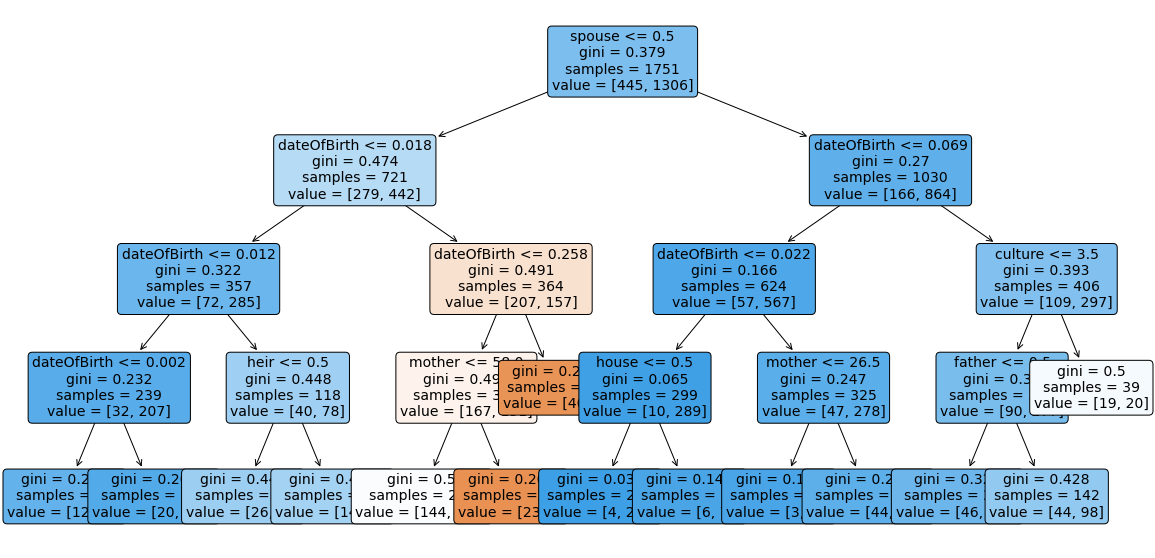

In [61]:
# setting figure size
plt.figure(figsize=(20, 10)) # adjusting to better fit the visual


# developing a plotted tree
plot_tree(decision_tree = pruned_tree_fit, # changing to pruned_tree_fit
          feature_names = df.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)


# rendering the plot
plt.show()

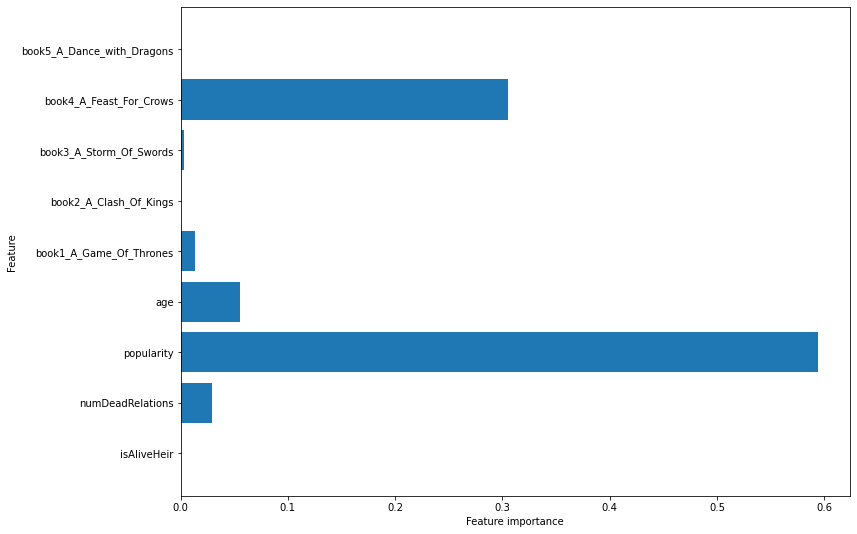

In [62]:
# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train = x_train,
                         export = False)

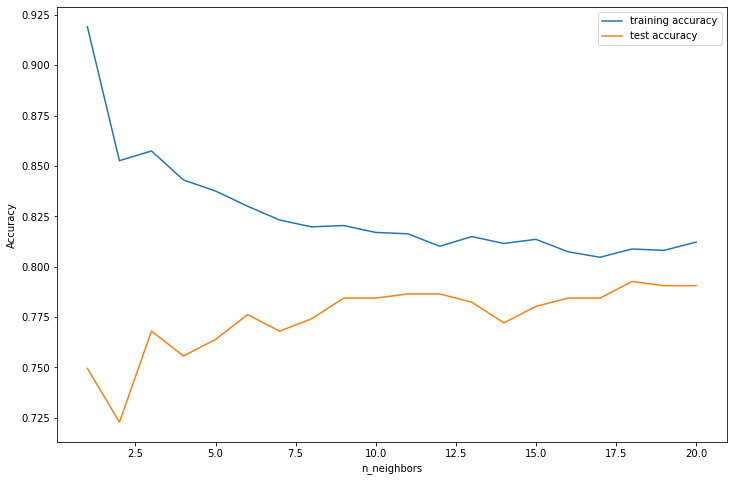

The optimal number of neighbors is: 18


In [63]:
# determining the optimal number of neighbors
opt_neighbors = optimal_neighbors(x_data        = df_data,
                                  y_data        = df_target,
                                  response_type = 'class')

In [64]:
# INSTANTIATING StandardScaler()
scaler = StandardScaler()


# FITTING the data
scaler.fit(df_data)


# TRANSFORMING the data
x_scaled     = scaler.transform(df_data)


# converting to a DataFrame
x_scaled_df  = pd.DataFrame(x_scaled) 


# train-test split with the scaled data
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
            x_scaled_df,
            df_target,
            random_state = 219,
            test_size    = 0.10,
            stratify     = df_target)


# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = opt_neighbors)


# FITTING the training data
knn_fit = knn_opt.fit(x_train_scaled, y_train_scaled)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(x_test_scaled)


# SCORING the results
print('Training ACCURACY:', knn_fit.score(x_train_scaled, y_train_scaled).round(4))
print('Testing  ACCURACY:', knn_fit.score(x_test_scaled, y_test_scaled).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4))


# saving scoring data
knn_train_score = knn_fit.score(x_train_scaled, y_train_scaled).round(4)
knn_test_score  = knn_fit.score(x_test_scaled, y_test_scaled).round(4)


# saving AUC score
knn_auc_score   = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)

Training ACCURACY: 0.8064
Testing  ACCURACY: 0.8103
AUC Score        : 0.7086


In [65]:
# unpacking the confusion matrix
knn_tree_tn, \
knn_tree_fp, \
knn_tree_fn, \
knn_tree_tp = confusion_matrix(y_true = y_test, y_pred = knn_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {knn_tree_tn}
False Positives: {knn_tree_fp}
False Negatives: {knn_tree_fn}
True Positives : {knn_tree_tp}
""")


True Negatives : 25
False Positives: 25
False Negatives: 12
True Positives : 133



In [72]:
# comparing results
print(f"""
Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic         {logreg_auc_score}      {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
* Full Tree      {full_tree_auc_score}      {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree      {pruned_tree_auc_score}        {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
Knn              {knn_auc_score}      {knn_tree_tn, knn_tree_fp, knn_tree_fn, knn_tree_tp}

* is the best model based on AUC score
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, pruned_tree_auc_score, knn_auc_score],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score, knn_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           pruned_tree_test_score, knn_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                          (knn_tree_tn, knn_tree_fp, knn_tree_fn, knn_tree_tp)]}





Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic         0.6431      (15, 35, 2, 143)
* Full Tree      0.7438      (33, 17, 25, 120)
Pruned Tree      0.59        (9, 41, 0, 145)
Knn              0.7086      (25, 25, 12, 133)

* is the best model based on AUC score

